<a href="https://colab.research.google.com/github/Avassophia/Tumor-Detection/blob/main/tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import math
import statistics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle


# Data Exploration

In [2]:
#load data and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()
df=pd.read_csv("data.csv")


Saving data.csv to data.csv


In [3]:
#visualize first five rows
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
#visualize first five rows

print(f"Number of columns: {df.shape[1]}")

#identify any missing values
missing_vals=df.isnull().sum()
missing_vals=missing_vals[missing_vals>0]
print(f"Missing values: {missing_vals}")

#Delete unnecesary column consisting of NaNs - now, there are no more missing values.
df=df.drop(columns=["Unnamed: 32"])

print(f"Data types:{df.dtypes.value_counts()}")
print(df.dtypes[df.dtypes == 'object'])
#Our target category is an object. I change B (benign) to equal 0,
# and M (malignant) to equal 1.

#We must encode the two classes, benign and malignant, as 0 and 1.
df['class']=df['diagnosis'].str.strip().str.upper().map({'B':0,'M':1})
df=df.drop(columns=['diagnosis'])

Number of columns: 33
Missing values: Unnamed: 32    569
dtype: int64
Data types:float64    30
int64       1
object      1
Name: count, dtype: int64
diagnosis    object
dtype: object


# Normalization
We normalize each numeric column to ensure all features are on the same scale, which will improve the performance of our algorithms. Normalization prevents features with larger ranges from dominating those with smaller ranges and ensures fair contribution from each variable.

In [5]:
numeric=df.select_dtypes(include=['int64','float64']).columns
for col in numeric:
  df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())

In [6]:
#visualize normalized data table
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,class
0,0.000915,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,1.0
1,0.000915,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,1.0
2,0.092495,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,1.0
3,0.092547,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,1.0
4,0.092559,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,1.0


# Feature Importance
Our dataset has 30 independent features. While it is theoretically possible to use all features when training our models, this approach can have adverse affects. For example, in KNN, using too many independent features can lead to the curse of dimensionality - in higher dimensions, point distance becomes less meaningful and KNN performance decreases.
We will solve this problem by identifying the **three** most meaningful features. We choose three so that the classification can be visualized on a 3D plot.
How do we determine the "meaningfulness" of a feature?
We take features one-by-one, analyzing how strongly they correlate with our target. Features that are highly correlated with the target often carry strong predictive signals.

In [7]:
correlations = df.corr()['class'].abs().sort_values(ascending=False)
#see the top correlated features with class (other than class itself)
top_12=correlations.head(12)
print(top_12)

class                   1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
compactness_mean        0.596534
Name: class, dtype: float64


Out of the features above, some pairs (e.g. area_worst and area_mean, or area_mean and radius_mean) are redundant. For example, area_worst measures the worst-case area across 10 measurements, and area-mean measures the average of these 10 measurements. We are ideally looking for features describing *different* properties. We will choose concave points_worst, perimeter_worst, and radius_worst.
- **concave points_worst**:  
  Number of inward dents along the tumor boundary in the worst (most irregular) instance.  
  → Measures **how many** concave points exist in the most distorted part of the tumor.

- **perimeter_worst**:  
  Perimeter of the tumor outline in the worst instance.  
  → Measures **total boundary length** when the tumor appears most irregular.

- **radius_worst**:  
  Radius of the circle approximating the tumor in the worst case.  
  → Calculated as **mean distance from the tumor center to its boundary** during worst appearance.

# Splitting the Data
We split our data into a training, validation, and testing set.

In [8]:
#We will use the sklearn libary, only for efficiently splitting the data into
#a training, validation, and testing set.
y=df['class']
X=df[['concave points_worst','perimeter_worst','radius_worst']]

from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#15 percent of the training data will be validation data.
val_size = 0.1875

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size, random_state=42
)

print(f"Train size: {X_train.shape[0]} samples")
print(f"Validation size: {X_val.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

print(len(X_train))
len(y_train)

Train size: 369 samples
Validation size: 86 samples
Test size: 114 samples
369


369

# K-Nearest Neighbors Algorithm
Below, we implement the K-Nearest Neighbors Algorithm from scratch.
We then run the algorithm for k=3 (the algorithm looks at the 3 nearest neighbors). We visualize these results through a 3d graph, where the axes represent our three features - concave points_worst, perimeter_worst, and radius_worst), and the color of each point represents the class it was assigned to (benign or malignant).

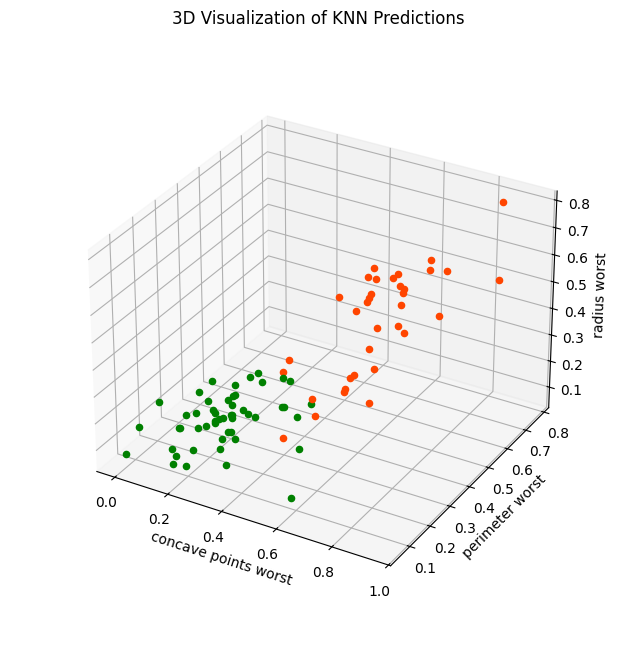

In [24]:
def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def knn(X_train, y_train, X_val, k,epsilon=1e-5):
    assignments = []
    for i in range(len(X_val)):
        distances = []
        for j in range(len(X_train)):
            dist = distance(X_train[j], X_val[i])
            distances.append((dist, y_train[j]))
        distances.sort(key=lambda x: x[0])
        k_closest = distances[:k]
        weights={}
        for dist,label in k_closest:
          weight=1/(epsilon+dist)
          weights[label]=weights.get(label,0)+weight
        chosen_class=max(weights,key=weights.get)
        assignments.append(chosen_class)
    return assignments



def plot_classes(assignments,X_val):
  fig=plt.figure(figsize=(10,8))
  ax = fig.add_subplot(111, projection='3d')
  #create lists of the x,y, and z coordinates for easy plotting
  x=[]
  y=[]
  z=[]
  for i in range(len(X_val)):
    x.append(X_val[i][0])
    y.append(X_val[i][1])
    z.append(X_val[i][2])

  for i in range(len(y_val)):
    if assignments[i]==0:
      color="green"
    else:
      color="orangered"
    ax.scatter(x[i],y[i],z[i],c=color)
  ax.set_xlabel('concave points worst')
  ax.set_ylabel('perimeter worst')
  ax.set_zlabel('radius worst')
  ax.set_title('3D Visualization of KNN Predictions')
  ax.set_box_aspect(None, zoom=0.85)
  plt.show()

#run the KNN algorithm, and plot results
assignments=knn(X_train,y_train,X_val,3)
plot_classes(assignments,X_val)




# What Metrics to Use?

In determining what metrics to use (accuracy, precision, recall, etc.), we will use two ideas. First, we will check for class imbalance. We define a dataset to be imbalanced if there exists a class that comprises less than 30% of the data.


In [10]:
portion_1s=(np.sum(y_train==1))
portion_0s=(np.sum(y_train==0))
total=len(y_train)
print(f"Benign tumors make up {(portion_0s/total)*100:.2f}% of the data.")
print(f"Malignant tumors make up {(portion_1s/total)*100:.2f}% of the data.")

Benign tumors make up 63.69% of the data.
Malignant tumors make up 36.31% of the data.


The dataset is not imbalanced. Thus, we will use accuracy as one of our metrics. However, we will use another metric - **recall**. Recall answers, out of all the true positives in our dataset, how many were correctly classified as so?

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

We use recall because in our tumor diagnosis project, false negatives are **significantly worse** than false positives. Failing to detect cancer in a patient is a more drastic problem than accidentally diagnosing someone. Recall tells us, out of all malignant tumors, how many were diagnosed as so? Thus, a high recall means our model performs well at detecting malignant tumors.

Finally, the last metric we will use is F1 score. **F1 Score**:  
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$, where precision is:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$
Precision answers, out of all classified positives, how many are true positives? The F1 score balances precision and recall, through the harmonic mean. Using the F1 score ensures that our model has not became super well at classifying malignant tumors only because it is frequently classifying positives. In other words, we do not want our model to be "over-classifying" positives.

In [11]:
#helper functions to compute our metrics
def compute_accuracy(assignments,y_train):
  correct=0
  for i in range(len(assignments)):
    if assignments[i]==y_train[i]:
      correct+=1
  total=len(assignments)
  if total!=0:
    accuracy=round(correct/total,2)
  else:
    accuracy=0
  return accuracy

def compute_recall(assignments,y_train):
  true_pos=0
  false_neg=0
  for i in range(len(assignments)):
    if y_train[i]==1:
      if assignments[i]==1:
        true_pos+=1
      else:
        false_neg+=1
  if true_pos+false_neg!=0:
    recall=round(true_pos/(true_pos+false_neg),2)
  else:
    recall=0
  return recall

def compute_precision(assignments,y_train):
  true_pos=0
  false_pos=0
  for i in range(len(assignments)):
    if assignments[i]==1:
      if y_train[i]==1:
        true_pos+=1
      else:
        false_pos+=1
  if true_pos+false_pos!=0:
    precision=true_pos/(true_pos+false_pos)
  else:
    precision=0
  return precision
def compute_f1(assignments,y_train):
  precision=compute_precision(assignments,y_train)
  recall=compute_recall(assignments,y_train)
  f1=(2*precision*recall)/(precision+recall)
  return f1





# Cross Validation
To find the best value for hyperparameter k, we will do 5-fold cross validation.

The highest accuracy is 0.95, when k=7.
The highest recall is 0.89, when k=1.


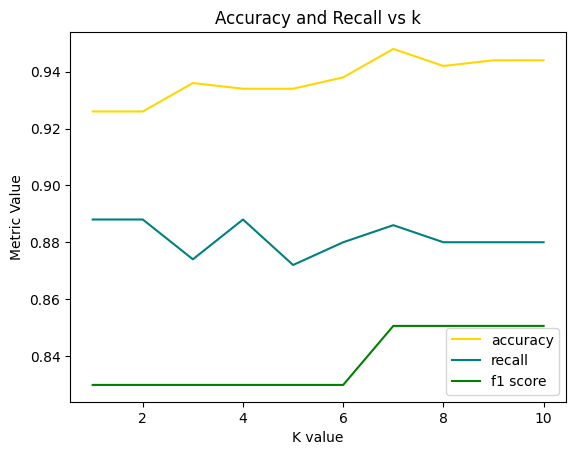

In [12]:
def crossval(X_train,y_train):
  N = len(X_train)  # 296
  fold_size = N // 5  # integer division → 59

  fold1 = X_train[0 : fold_size]              # 0 to 58 (59 samples)
  fold2 = X_train[fold_size : 2*fold_size]    # 59 to 117
  fold3 = X_train[2*fold_size : 3*fold_size]  # 118 to 176
  fold4 = X_train[3*fold_size : 4*fold_size]  # 177 to 235
  fold5 = X_train[4*fold_size : ]              # 236 to end (296) — may have extra samples

  # Same for y_train
  class1 = y_train[0 : fold_size]
  class2 = y_train[fold_size : 2*fold_size]
  class3 = y_train[2*fold_size : 3*fold_size]
  class4 = y_train[3*fold_size : 4*fold_size]
  class5 = y_train[4*fold_size : ]
  folds=[fold1,fold2,fold3,fold4,fold5]
  classes=[class1,class2,class3,class4,class5]

  trainsets=[]
  valsets=[]
  classsets=[]
  for i in range(len(folds)):
    group = np.vstack([folds[(i + j) % 5] for j in range(4)])
    classgroup=np.hstack([classes[(i + j) % 5] for j in range(4)])
    testgroup=folds[(i +4) % 5]
    trainsets.append(group)
    classsets.append(classgroup)
    valsets.append(testgroup)


  avg_accuracies=[]
  avg_recalls=[]
  avg_f1s=[]
  for k in range(1, 11):
      total_accuracy=0
      total_recall=0
      total_f1=0
      for i in range(len(trainsets)):
          X_train = trainsets[i]
          y_train = classsets[i]
          X_val = valsets[i]
          y_val = classes[(i + 4) % 5]

          assignments = knn(X_train, y_train, X_val, k)
          accuracy = compute_accuracy(assignments, y_val)
          recall=compute_recall(assignments,y_val)
          f1=compute_f1(assignments,y_val)
          total_accuracy+=accuracy
          total_recall+=recall
          total_f1+=f1

      avg_accuracy = total_accuracy/len(trainsets)
      #print(f"Avg accuracies for k={k} = {avg_accuracy:.2f}")
      avg_recall=total_recall/len(trainsets)
      avg_f1=total_f1/len(trainsets)
      avg_accuracies.append(avg_accuracy)
      avg_recalls.append(avg_recall)
      avg_f1s.append(f1)



  k_vals = list(range(1, 11))
  plt.xlabel("K value")
  plt.ylabel("Metric Value")
  plt.title("Accuracy and Recall vs k")
  #plot k val vs accuracy, and k val vs recall
  plt.plot(k_vals, avg_accuracies, c="gold",label="accuracy")
  plt.plot(k_vals, avg_recalls, c="teal",label="recall")
  plt.plot(k_vals, avg_f1s, c="green",label="f1 score")


  # All k values with max accuracy
  max_acc = max(avg_accuracies)
  acc_indices = [i for i, val in enumerate(avg_accuracies) if val == max_acc]
  acc_index = min(acc_indices)  # or max(...) if you prefer highest k

  # Same for recall
  max_rec = max(avg_recalls)
  rec_indices = [i for i, val in enumerate(avg_recalls) if val == max_rec]
  rec_index = min(rec_indices)
  print(f"The highest accuracy is {max_acc:.2f}, when k={k_vals[acc_index]}.")
  print(f"The highest recall is {max_rec:.2f}, when k={k_vals[rec_index]}.")
  #plt.axhline(y=max_acc, color='orange', linestyle='--', linewidth=2, label='highest accuracy')
  plt.legend()
  plt.show()

crossval(X_train,y_train)

Upon inspection, we see that accuracy, recall, and F1 score are consistently high at k=1. We will set k=1, and evaluate how our model performs on the testing data.

# Analysis
We will evaluate our KNN classifier using three metrics- accuracy, precision, and recall. Accuracy is the number of correct predictions (true positives and true negatives), divided by the number of total predictions. Precision measures - out of all points classified as positive, how many are actually positive? Recall measures - out of all true positives, how many did the model classify as postive? Ideally, we want both high precision and high recall. We will plot these 3 metrics for different values of K.

In [13]:
#run KNN with k=1 on test data
test_assignments = knn(X_train, y_train, X_test,k=1,epsilon=1e-5)
test_accuracy=compute_accuracy(test_assignments,y_test)
test_recall=compute_recall(test_assignments,y_test)
test_f1=compute_f1(test_assignments,y_test)
print(f"Our validation accuracy was 0.96; our test accuracy is {test_accuracy:.2f}.")
print(f"Our validation recall was 0.95; our test recall is {test_recall:.2f}.")
print(f"Our validation f1 score was 0.92; our test f1 score is {test_f1:.2f}.")


Our validation accuracy was 0.96; our test accuracy is 0.95.
Our validation recall was 0.95; our test recall is 0.91.
Our validation f1 score was 0.92; our test f1 score is 0.93.


# Analysis
Our model is performing well, with a 95% percent accuracy, and both recall
and f1 score above 90%. For a final analysis metric, we will visualize the confusion matrix to understand what types of errors (false positives or false negatives) our model is more commonly making. We will use sk.learn to easily display the matrix.

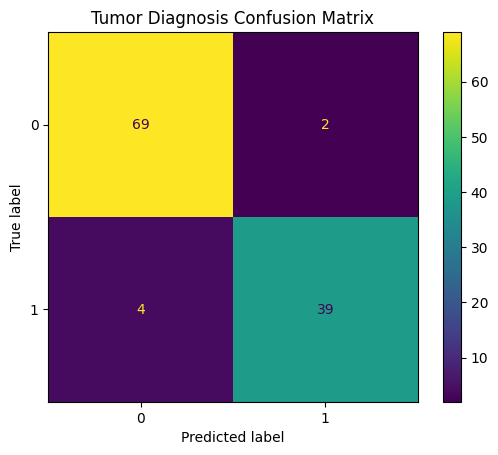

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_test, test_assignments)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

disp.plot(cmap=plt.cm.viridis)
plt.title("Tumor Diagnosis Confusion Matrix")
plt.show()

## Analysis of confusion matrix
Overall, our model makes relatively few mistakes. While it technically makes more errors in false negatives than false positives (4 as opposed to 2), this is not a significant difference. Overall, the model performs well both in terms of precision and recall.

# Conclusion/Summary
In this project, we implemented a k-Nearest Neighbors classifier to predict tumor malignancy using selected features from the dataset. We carefully split the data into training, validation, and test sets, ensuring proper stratification and preprocessing.
Hyperparameter tuning via cross-validation identified
k=1 as the best choice. The final model achieved an accuracy of 95%, recall of 91%, and F1 score of 93% on the test set, indicating strong overall performance and good sensitivity to positive cases.
### Limitations
We chose k = 1 due to consistent high performance on all metrics. However, for other classification tasks, k = 1 can lead to overfitting, meaning the model performs very well on training data but fails to generalize well to unseen data.
Additionally, our dataset had somewhat imbalanced classes (around a 60-40 split). KNN may have biased predictions toward the more frequent class — benign tumors — which could affect its ability to correctly classify the less frequent malignant cases.

### Further Directions
To improve performance on this dataset, different classifications, such as logitistic regression, support vector machines, or random forests, can be tried. Logistic regression can perform better with high-dimensional data, and could imporve performance by including more features within the model. Random forests are in general more robust to noise than KNN, as many decision trees are making decisions.

Another further exploration is to select features differently by using Principal Component Analysis (PCA), which is a more rigorous apporach than only using correlation coefficients. PCA is a dimensionality reduction technique - it finds the directions in the data that capture the most variance. Using PCA could ensure that we pick the most relevant features for cancer diagnosis.

## References

**Dataset:**  
Dua, D. and Graff, C. (2019). *UCI Machine Learning Repository: Breast Cancer Wisconsin (Diagnostic) Data Set*. Irvine, CA: University of California, School of Information and Computer Science.  
Retrieved from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
